In [1]:
train_path = '/kaggle/input/paddy-disease-classification-2/train_images/'
test_path  = '/kaggle/input/paddy-disease-classification-2/test_images/'

!du --inodes '/kaggle/input/paddy-disease-classification-2/train_images/'
!du --inodes '/kaggle/input/paddy-disease-classification-2/test_images/'

import glob
from pathlib import Path

for filepath in glob.glob(train_path + '/*/'):
    files = glob.glob(filepath + '*')
    print(f"{len(files)} \t {Path(filepath).name}")

files = glob.glob(test_path + '/*')
print(f"{len(files)} \t {Path(test_path).name}") 

1562	/kaggle/input/paddy-disease-classification-2/train_images/tungro
614	/kaggle/input/paddy-disease-classification-2/train_images/yellow_stem_borer
1721	/kaggle/input/paddy-disease-classification-2/train_images/hispa
695	/kaggle/input/paddy-disease-classification-2/train_images/downy_mildew
406	/kaggle/input/paddy-disease-classification-2/train_images/black_stem_borer
406	/kaggle/input/paddy-disease-classification-2/train_images/bacterial_leaf_streak
519	/kaggle/input/paddy-disease-classification-2/train_images/bacterial_leaf_blight
1005	/kaggle/input/paddy-disease-classification-2/train_images/brown_spot
1882	/kaggle/input/paddy-disease-classification-2/train_images/blast
877	/kaggle/input/paddy-disease-classification-2/train_images/leaf_roller
1925	/kaggle/input/paddy-disease-classification-2/train_images/normal
361	/kaggle/input/paddy-disease-classification-2/train_images/bacterial_panicle_blight
1020	/kaggle/input/paddy-disease-classification-2/train_images/white_stem_borer
12994

In [2]:
import numpy as np
import pandas as pd
import pickle
import cv2
import os

from os import listdir
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import keras
keras.__version__
from psutil import virtual_memory

SEED = 123
EPOCHS = 100
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
width = 256
height = 256
depth = 3

n_classes = len(glob.glob(train_path + '/*/'))
print(n_classes)

13


2022-07-18 06:16:37.384124: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-18 06:16:37.489204: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-18 06:16:37.489978: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-18 06:16:37.491296: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

channels_last


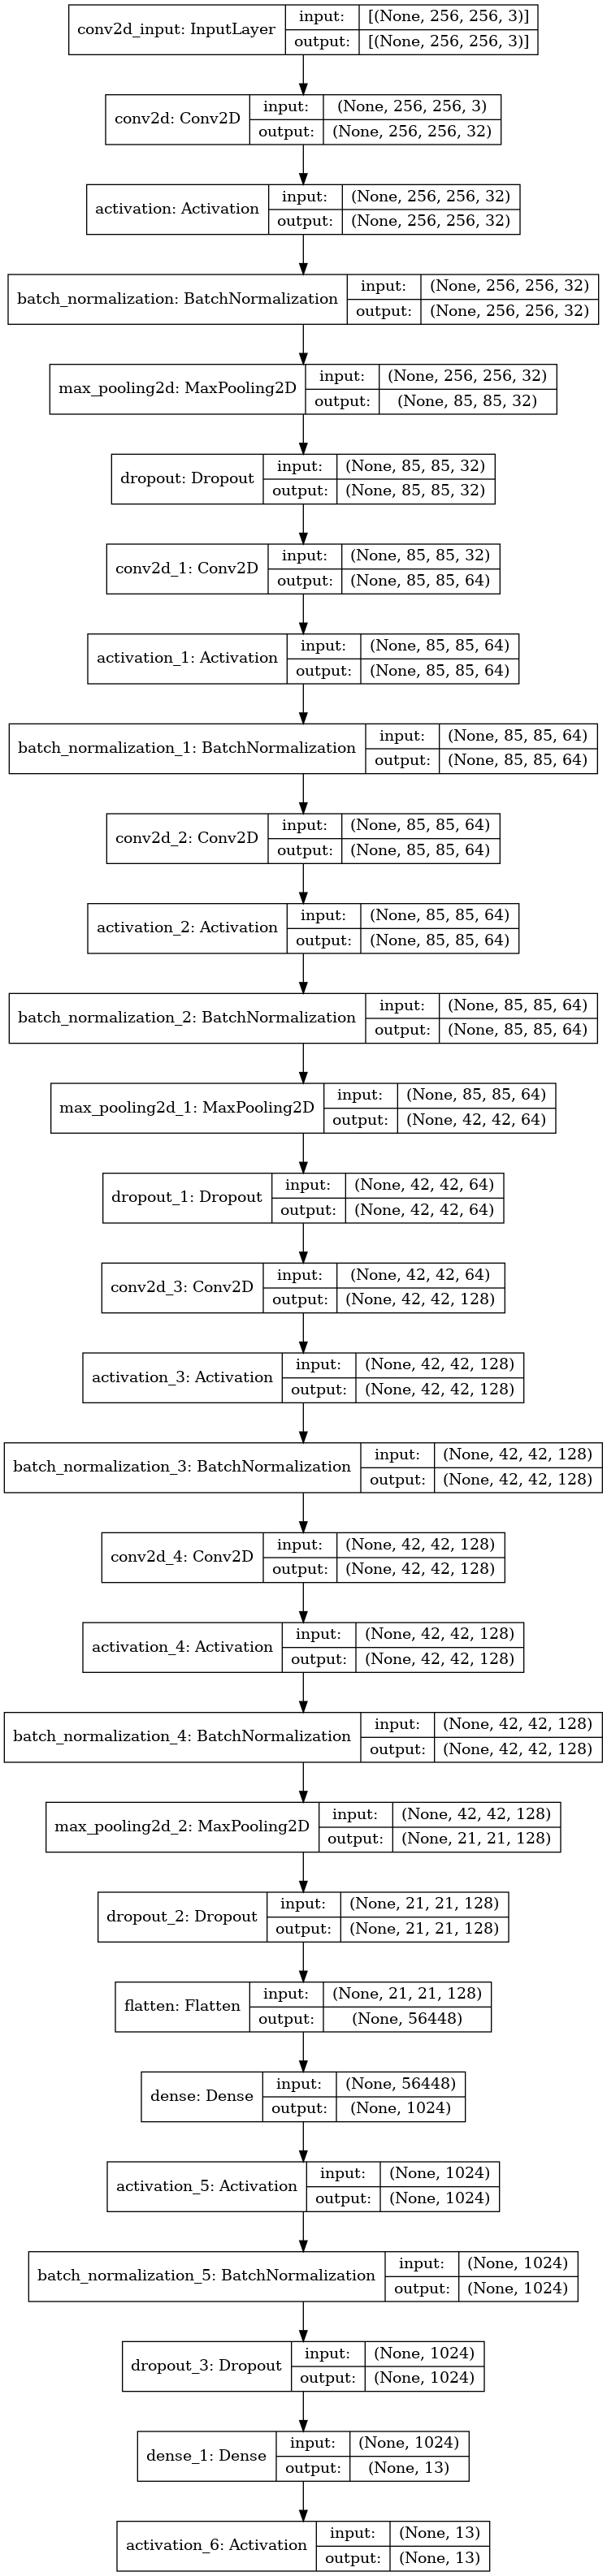

In [3]:
def get_model():
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1
    print(K.image_data_format())
    if K.image_data_format() == "channels_first":
        inputShape = (depth, height, width)
        chanDim = 1
    model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(n_classes))
    model.add(Activation("softmax"))
    
    opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    # distribution
    model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
    return model
model = get_model()

plot_model(model, '/kaggle/working/model.png', show_shapes=True)

In [4]:
image_datagen = ImageDataGenerator(featurewise_center=False,
                 samplewise_center=False,
                 featurewise_std_normalization=False,
                 samplewise_std_normalization=False,
                 zca_whitening=False,
                 rotation_range=5,
                 shear_range=0.2,
                 zoom_range=0.2,
                 width_shift_range=0.05,
                 height_shift_range=0.05,
                 channel_shift_range=0.,
                 fill_mode='nearest',
                 horizontal_flip=True,
                 vertical_flip=False,
                 rescale=1./255,
                                   validation_split=0.2)

train_generator = image_datagen.flow_from_directory(    
    directory = train_path,
    subset='training',
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=SEED)

valid_generator = image_datagen.flow_from_directory(    
    directory=train_path,
    subset='validation',
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=SEED)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(    
    directory=test_path,
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=1,
    classes=['.'],
    class_mode=None,
    shuffle=False,
    seed=SEED)

print(train_generator.class_indices)
print(test_generator.samples)

Found 10389 images belonging to 13 classes.
Found 2591 images belonging to 13 classes.
Found 3245 images belonging to 1 classes.
{'bacterial_leaf_blight': 0, 'bacterial_leaf_streak': 1, 'bacterial_panicle_blight': 2, 'black_stem_borer': 3, 'blast': 4, 'brown_spot': 5, 'downy_mildew': 6, 'hispa': 7, 'leaf_roller': 8, 'normal': 9, 'tungro': 10, 'white_stem_borer': 11, 'yellow_stem_borer': 12}
3245


In [5]:
%%time
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
history = model.fit_generator(generator = train_generator,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = valid_generator,
                    validation_steps = STEP_SIZE_VALID,
                    epochs=EPOCHS)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-07-18 06:16:44.984372: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-07-18 06:16:47.636626: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


324/324 [==============================] - 284s 849ms/step - loss: 0.3782 - accuracy: 0.2476 - val_loss: 2.8236 - val_accuracy: 0.1230
Epoch 2/100
324/324 [==============================] - 237s 730ms/step - loss: 0.2218 - accuracy: 0.4186 - val_loss: 0.3238 - val_accuracy: 0.3219
Epoch 3/100
324/324 [==============================] - 234s 724ms/step - loss: 0.1933 - accuracy: 0.5039 - val_loss: 0.3338 - val_accuracy: 0.2527
Epoch 4/100
324/324 [==============================] - 234s 724ms/step - loss: 0.1750 - accuracy: 0.5518 - val_loss: 0.2176 - val_accuracy: 0.4402
Epoch 5/100
324/324 [==============================] - 235s 725ms/step - loss: 0.1541 - accuracy: 0.6148 - val_loss: 0.2042 - val_accuracy: 0.4797
Epoch 6/100
324/324 [==============================] - 236s 727ms/step - loss: 0.1518 - accuracy: 0.6207 - val_loss: 0.1518 - val_accuracy: 0.6348
Epoch 7/100
324/324 [==============================] - 235s 725ms/step - loss: 0.1262 - accuracy: 0.7017 - val_loss: 0.1159 - val_

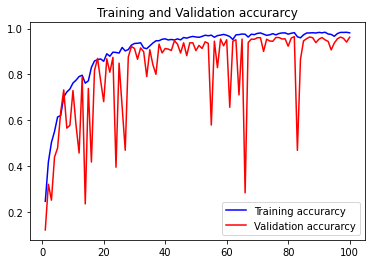

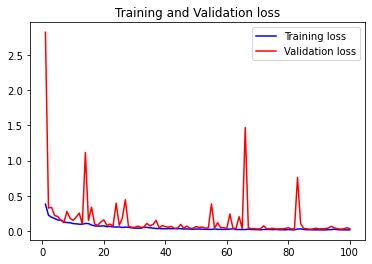

CPU times: user 447 ms, sys: 173 ms, total: 619 ms
Wall time: 365 ms


In [6]:
%%time
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [7]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
pred = model.predict_generator(test_generator,
                               steps=STEP_SIZE_TEST,
                               verbose=1)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


3245/3245 [==============================] - 40s 12ms/step


In [8]:
loss, acc = model.evaluate_generator(test_generator, steps=STEP_SIZE_TEST, verbose=1)
print(acc, loss)

   1/3245 [..............................] - ETA: 6:58 - loss: 0.0000e+00 - accuracy: 0.0000e+00

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


3245/3245 [==============================] - 23s 7ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
0.0 0.0


In [9]:
pd.Series(train_generator.classes).value_counts()

9     1540
4     1505
7     1376
10    1249
11     816
5      804
8      701
6      556
12     491
0      415
1      324
3      324
2      288
dtype: int64

In [10]:
pd.Series(test_generator.classes).value_counts()

0    3245
dtype: int64

In [11]:
predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generator.class_indices)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

pd.Series(predictions).value_counts()

normal                      495
blast                       469
hispa                       428
tungro                      382
white_stem_borer            263
brown_spot                  246
leaf_roller                 223
downy_mildew                172
yellow_stem_borer           154
bacterial_leaf_blight       127
bacterial_leaf_streak       105
black_stem_borer             95
bacterial_panicle_blight     86
dtype: int64

In [12]:
filenames=test_generator.filenames

results=pd.DataFrame({"image_id":filenames,
                      "label":predictions})
results.image_id = results.image_id.str.replace('./', '')
results.to_csv("submission.csv",index=False)
results.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """


,image_id,label
0,200001.jpg,white_stem_borer
1,200002.jpg,hispa
2,200003.jpg,bacterial_leaf_streak
3,200004.jpg,black_stem_borer
4,200005.jpg,normal
